In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import joblib

# Add project root to path
sys.path.append(os.path.abspath(".."))

# Set random seed for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

pd.set_option('display.max_columns', None)

## 1. Load Data & Features
We load the raw data and apply the *latest* feature engineering logic (Exp 17).

In [2]:
import src.features
import importlib
importlib.reload(src.features)
from src.features import extract_user_attributes, generate_training_data, aggregate_user_features

print("Loading Raw Data...")
train_df_raw = pd.read_parquet('../data/train.parquet')
test_df_raw = pd.read_parquet('../data/test.parquet')

print("Applying Feature Engineering (Exp 17)...")
# 1. Extract Attributes
train_df_raw = extract_user_attributes(train_df_raw)
test_df_raw = extract_user_attributes(test_df_raw)

# 2. Generate Training Data (Snapshots)
df_train = generate_training_data(train_df_raw)

# 3. Generate Test Data (Single Snapshot at End)
global_max_ts = test_df_raw['ts'].max()
test_snapshot_df = pd.DataFrame({
    'userId': test_df_raw['userId'].unique(),
    'cutoff_ts': global_max_ts
})
df_test = aggregate_user_features(test_df_raw, snapshot_df=test_snapshot_df)
df_test = df_test.reset_index(level='cutoff_ts', drop=True)

# Align Columns
cols_to_drop = ["target", "userId", "cutoff_ts"]
X_train = df_train.drop(columns=[c for c in cols_to_drop if c in df_train.columns])
X_test = df_test[X_train.columns]

print(f"Train Shape: {X_train.shape}")
print(f"Test Shape: {X_test.shape}")

Loading Raw Data...
Applying Feature Engineering (Exp 17)...
Applying Feature Engineering (Exp 17)...
Generated 85807 snapshots.
Class Balance: 12.28%
Generated 85807 snapshots.
Class Balance: 12.28%
Train Shape: (85807, 49)
Test Shape: (2904, 49)
Train Shape: (85807, 49)
Test Shape: (2904, 49)


## 2. Covariate Shift Analysis
We compare the distribution of features in the Training Set (Snapshots) vs the Test Set (Full History).
Large divergences indicate "Toxic Features" that will confuse the model.

**Key Metric**: Mean Percentage Difference.
$$ \text{Diff} = \frac{\mu_{train} - \mu_{test}}{\mu_{train} + \epsilon} $$

Top 10 Most Divergent Features (Potential Toxicity):
                         mean_train      std_train      mean_test  \
errors_last_30d            0.358654       0.827241       0.934917   
errors_last_14d            0.177620       0.536545       0.451446   
errors_last_7d             0.092067       0.358381       0.222452   
listen_time_last_30d   73751.554946  119702.755444  165295.970460   
songs_last_30d           296.550363     481.241818     664.537534   
unique_songs_last_30d    271.514107     417.459357     605.902204   
unique_songs_last_14d    137.419418     251.609618     305.611570   
songs_last_14d           145.895370     275.853936     324.223140   
listen_time_last_14d   36285.863452   68616.385838   80602.956314   
thumbs_down_last_30d       3.441817       5.832796       7.620179   

                            std_test  mean_diff_pct  abs_diff_pct  
errors_last_30d             8.351532      -1.606741      1.606741  
errors_last_14d             4.020236      -1.541648

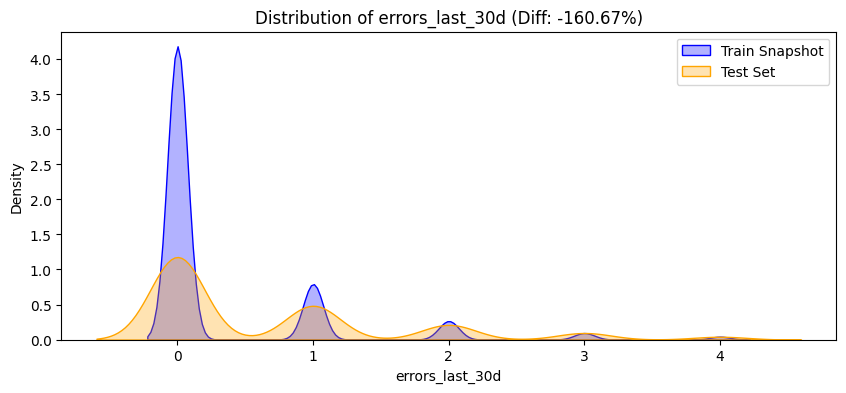

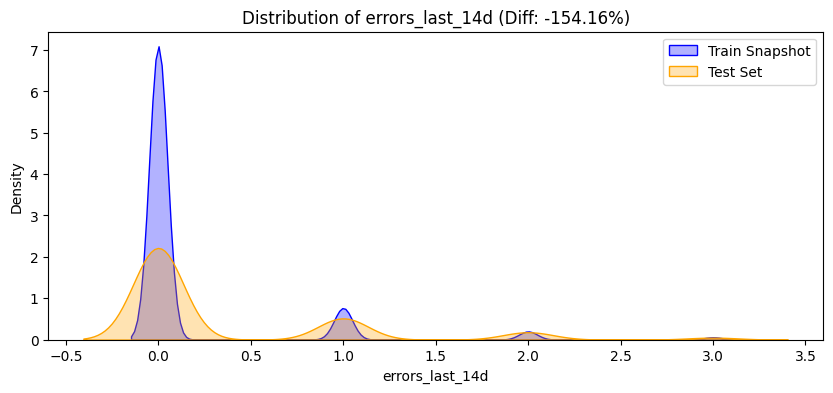

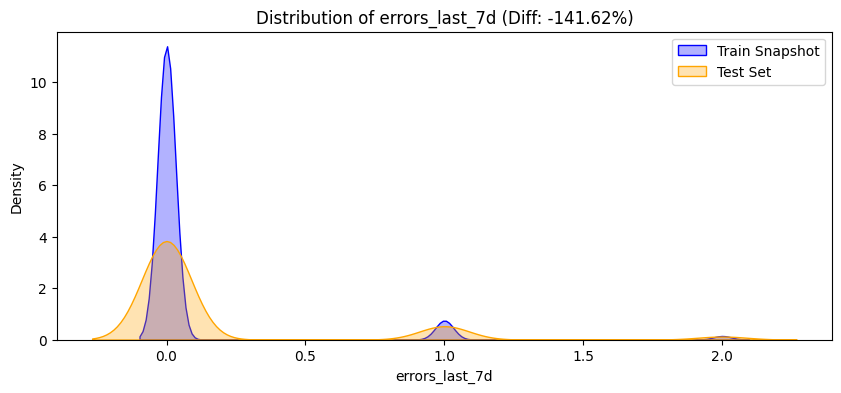

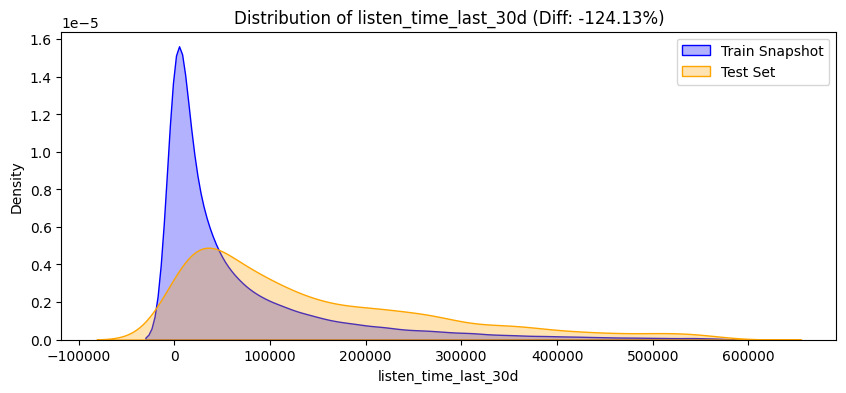

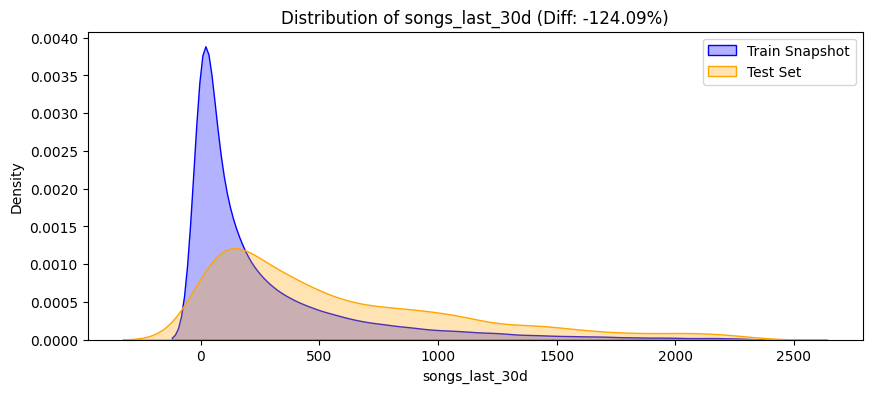

In [3]:
# Calculate Statistics
train_stats = X_train.describe().T[['mean', 'std']]
test_stats = X_test.describe().T[['mean', 'std']]

# Compare
comparison = train_stats.join(test_stats, lsuffix='_train', rsuffix='_test')
comparison['mean_diff_pct'] = (comparison['mean_train'] - comparison['mean_test']) / (comparison['mean_train'] + 1e-9)
comparison['abs_diff_pct'] = comparison['mean_diff_pct'].abs()

print("Top 10 Most Divergent Features (Potential Toxicity):")
print(comparison.sort_values(by='abs_diff_pct', ascending=False).head(10))

# Plot Top 5 Divergent Features
top_divergent = comparison.sort_values(by='abs_diff_pct', ascending=False).head(5).index.tolist()

for f in top_divergent:
    plt.figure(figsize=(10, 4))
    # Clip outliers for better visualization
    q99 = X_train[f].quantile(0.99)
    data_train = X_train[X_train[f] <= q99][f]
    data_test = X_test[X_test[f] <= q99][f]
    
    sns.kdeplot(data_train, label='Train Snapshot', fill=True, color='blue', alpha=0.3)
    sns.kdeplot(data_test, label='Test Set', fill=True, color='orange', alpha=0.3)
    plt.title(f"Distribution of {f} (Diff: {comparison.loc[f, 'mean_diff_pct']:.2%})")
    plt.legend()
    plt.show()

## 3. Feature Importance Analysis
We load the trained model (Last Exp) and analyze which features are driving the predictions.

In [4]:
# Load Model
model_path = "../models/stacking_model.joblib"
if os.path.exists(model_path):
    print(f"Loading model from {model_path}...")
    model = joblib.load(model_path)
    
    # Extract Feature Names
    # Try to load from file first
    features_path = "../models/feature_names.joblib"
    if os.path.exists(features_path):
        feature_names = joblib.load(features_path)
    else:
        feature_names = X_train.columns

    # Analyze Importance (if VotingClassifier)
    if hasattr(model, 'estimators_'):
        print("Analyzing Voting Ensemble Importance...")
        
        # We need to handle the Preprocessor transformation
        # Ideally we should have saved the preprocessor too
        preprocessor_path = "../models/preprocessor.joblib"
        if os.path.exists(preprocessor_path):
            preprocessor = joblib.load(preprocessor_path)
            try:
                transformed_names = preprocessor.get_feature_names_out()
            except:
                # Fallback if get_feature_names_out fails or sklearn version issue
                transformed_names = feature_names # This might be wrong size if OHE used
        else:
            transformed_names = feature_names

        # Collect Importances
        importances = []
        # CRITICAL FIX: Iterate over FITTED estimators (estimators_) not the definitions (estimators)
        for (name, _), fitted_pipe in zip(model.estimators, model.estimators_):
            if hasattr(fitted_pipe, 'named_steps') and 'classifier' in fitted_pipe.named_steps:
                clf = fitted_pipe.named_steps['classifier']
                if hasattr(clf, 'feature_importances_'):
                    imp = clf.feature_importances_
                    
                    # Ensure imp is an array/list with length (handles numpy scalars)
                    if hasattr(imp, '__len__'):
                        # Check length match
                        if len(imp) == len(transformed_names):
                            importances.append(pd.Series(imp, index=transformed_names, name=name))
                        else:
                            print(f"⚠️ Shape mismatch for {name}: Model {len(imp)} vs Names {len(transformed_names)}")
                    else:
                        print(f"⚠️ {name} feature_importances_ is not array-like (Type: {type(imp)})")
        
        if importances:
            imp_df = pd.concat(importances, axis=1)
            imp_df['mean_importance'] = imp_df.mean(axis=1)
            imp_df = imp_df.sort_values(by='mean_importance', ascending=False)
            
            print("\nTop 20 Features:")
            print(imp_df.head(20))
            
            plt.figure(figsize=(10, 8))
            sns.barplot(x='mean_importance', y=imp_df.head(20).index, data=imp_df.head(20))
            plt.title("Ensemble Feature Importance")
            plt.show()
        else:
            print("Could not extract feature importances from base estimators.")
else:
    print("Model not found. Run Modeling.ipynb first.")

Loading model from ../models/stacking_model.joblib...
Analyzing Voting Ensemble Importance...
⚠️ Shape mismatch for xgb: Model 49 vs Names 48
⚠️ Shape mismatch for lgbm: Model 49 vs Names 48
⚠️ Shape mismatch for cat: Model 49 vs Names 48
⚠️ Shape mismatch for rf: Model 49 vs Names 48
Could not extract feature importances from base estimators.
Analyzing Voting Ensemble Importance...
⚠️ Shape mismatch for xgb: Model 49 vs Names 48
⚠️ Shape mismatch for lgbm: Model 49 vs Names 48
⚠️ Shape mismatch for cat: Model 49 vs Names 48
⚠️ Shape mismatch for rf: Model 49 vs Names 48
Could not extract feature importances from base estimators.
